In [2]:
import sqlite3
import pandas as pd

# Ruta a tu archivo de base de datos
db_path = "/Users/edgarpreciado/Downloads/chinook.db"

# Conexión
conn = sqlite3.connect(db_path)

# Crear un cursor (opcional, solo si quieres ejecutar comandos uno por uno)
cursor = conn.cursor()

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import os
print(os.path.exists(db_path))

True


## 🔹 Consultas básicas (calentamiento)

### ¿Cuántos clientes hay en cada país?

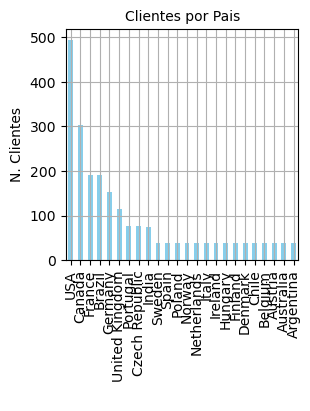

In [156]:
query = """
select i.BillingCountry as Country, Count(i.BillingCountry) as N_Clientes from invoice_items ii
inner join invoices i on ii.InvoiceId = i.InvoiceId
group by Country order by N_Clientes DESC;
"""

df = pd.read_sql_query(query, conn)
df.plot(
    kind="bar",        # tipo de gráfico
    x="Country",          # eje X
    y="N_Clientes",        # eje Y
    legend=False,      # sin leyenda
    color="skyblue",     # color opcional
    label = 'Ventas', 
    figsize=(3,3), 
    xlabel = " ", 
    ylabel = "N. Clientes")

plt.title("Clientes por Pais", fontsize = 10)
plt.grid()
plt.show()

### Lista los 10 artistas con más álbumes registrados.

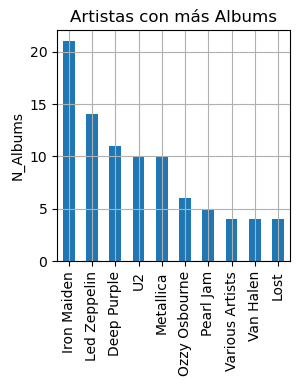

In [161]:
query = """
SELECT a2.Name as Artist , Count(a2.Name) as N_Albums from albums a
inner join artists a2 on a.ArtistId  = a2.ArtistId
group by Artist order by N_Albums DESC
limit 10; 

"""
df = pd.read_sql_query(query, conn)
df.set_index("Artist")['N_Albums'].plot(
    figsize=(3,3),
    kind="bar",   
    legend=False, 
    #autopct="%1.1f%%", 
    ylabel="N_Albums", 
    xlabel="")
plt.title("Artistas con más Albums")
plt.grid()
plt.show()

### ¿Qué géneros tienen más canciones en la base de datos?

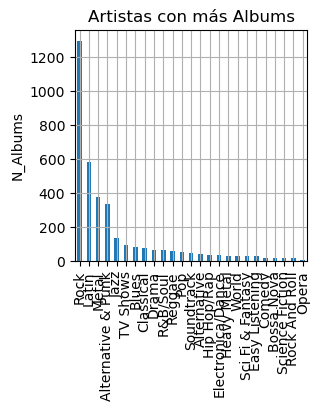

In [162]:
query = """
select g.Name as Genero,  count(t.GenreId) as N_Canciones from tracks t
inner join genres g  on t.GenreId = g.GenreId 
group by t.GenreId order by N_Canciones DESC ; 

"""
df = pd.read_sql_query(query, conn)
df.set_index("Genero")['N_Canciones'].plot(
    figsize=(3,3),
    kind="bar",   
    legend=False, 
    #autopct="%1.1f%%", 
    ylabel="N_Canciones", 
    xlabel="")
plt.title("Artistas con más Albums")
plt.grid()
plt.show()

### ¿Qué empleados trabajan en cada ciudad y quién es su jefe?

In [167]:
query = """
select concat(e.FirstName, e.LastName) as Empleado, e.City, concat(e2.FirstName, e2.LastName) as Manager from employees e
inner join employees e2 on e.ReportsTo = e2.EmployeeId limit 8;
"""
df = pd.read_sql_query(query, conn)
df.head(8)


,Empleado,City,Manager
0,NancyEdwards,Calgary,AndrewAdams
1,JanePeacock,Calgary,NancyEdwards
2,MargaretPark,Calgary,NancyEdwards
3,SteveJohnson,Calgary,NancyEdwards
4,MichaelMitchell,Calgary,AndrewAdams
5,RobertKing,Lethbridge,MichaelMitchell
6,LauraCallahan,Lethbridge,MichaelMitchell


## Consultas intermedias (JOINs dobles o triples)

### Cancion, Artista y Precio UNITARIO

In [13]:
query = """
SELECT 
    t.Name AS Cancion,
    ar.Name AS Artista,
    il.UnitPrice AS PrecioUnitario
FROM invoice_items il
JOIN tracks t ON il.TrackId = t.TrackId
JOIN albums al ON t.AlbumId = al.AlbumId
JOIN artists ar ON al.ArtistId = ar.ArtistId
ORDER BY il.UnitPrice DESC
LIMIT 5;
"""

df = pd.read_sql_query(query, conn)
df.head()

,Cancion,Artista,PrecioUnitario
0,Occupation / Precipice,Battlestar Galactica,1.99
1,Hero,Battlestar Galactica,1.99
2,The Woman King,Battlestar Galactica,1.99
3,"Crossroads, Pt. 2",Battlestar Galactica,1.99
4,Better Halves,Heroes,1.99


### ¿Cuál es la canción qué más ha vendido (según el precio unitario en `InvoiceLine`)? 
The Trooper 4.95 en ventas.  

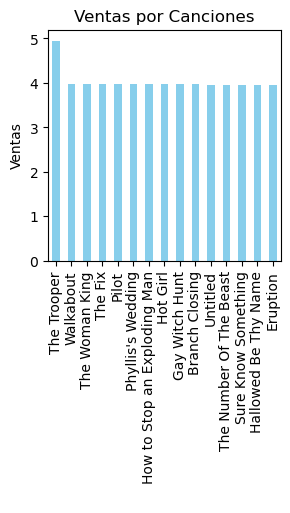

In [114]:
### ¿Cuál es la canción qué más ha vendido (según el precio unitario en `InvoiceLine`)? 
query = """
select t.Name as Name, Sum(ii.UnitPrice) as Venta_Total from invoices i 
inner join invoice_items ii on ii.InvoiceId  = i.InvoiceId
inner join tracks t on t.TrackId  = ii.TrackId 
GROUP by Name order by Venta_Total DESC limit 15; 

"""

df = pd.read_sql_query(query, conn)
df.head()

df.plot(
    kind="bar",        # tipo de gráfico
    x="Name",          # eje X
    y="Venta_Total",        # eje Y
    legend=False,      # sin leyenda
    color="skyblue", 
    figsize=(3,3), 
    xlabel = " "# color opcional
)
plt.title("Ventas por Canciones")
plt.ylabel("Ventas")
plt.show()


### --- - ¿Qué artista tiene más canciones en la base de datos y cuántas?  

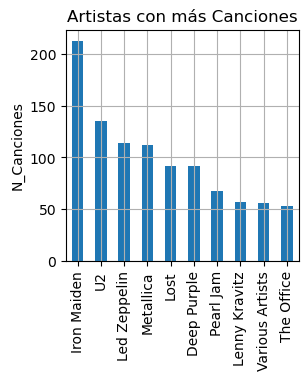

In [171]:
query = """
select ar.Name as Artist, COUNT(t.AlbumId ) as Cuenta from tracks t  
inner join albums a on a.AlbumId = t.AlbumId 
inner join artists ar on ar.ArtistId = a.ArtistId
GROUP by Artist order by Cuenta DESC limit 10; 

"""

df = pd.read_sql_query(query, conn)

df.set_index("Artist")['Cuenta'].plot(
    figsize=(3,3),
    kind="bar",   
    legend=False, 
    #autopct="%1.1f%%", 
    ylabel="N_Canciones", 
    xlabel="")
plt.title("Artistas con más Canciones")
plt.grid()
plt.show()

### Lista los 5 clientes principales de cada país (Top 5 por país en gasto).


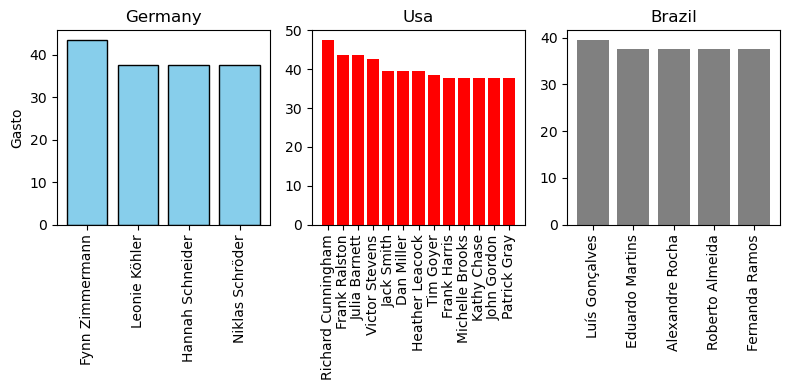

In [204]:
query = """
select concat(c.FirstName, ' ', c.LastName) as Name, i.BillingCountry as Country, Sum(i.Total) as Gasto from invoices i 
inner join customers c on c.CustomerId = i.CustomerId 
where i.BillingCountry in ('USA' , 'Canada', 'France', 'Brazil', 'Germany')
group by i.CustomerId order by i.BillingCountry DESC, gasto DESC; 

"""

df = pd.read_sql_query(query, conn)
df_usa = df[df["Country"] == "USA"]
df_BRAZIL = df[df["Country"] == "Brazil"]
df_Germany = df[df["Country"] == "Germany"]


# Crear figura con 2 subplots (2 filas, 1 columna)
fig, axs = plt.subplots(1, 3, figsize=(8, 4))

# Primer subplot
axs[0].bar(df_Germany['Name'], df_Germany['Gasto'], color="skyblue", edgecolor="black")
axs[0].set_title("Germany")
axs[0].set_ylabel("Gasto")
axs[0].tick_params(axis="x", rotation=90)
# Segundo subplot
axs[1].bar(df_usa['Name'], df_usa['Gasto'], color="red")
axs[1].set_title("Usa")
axs[1].tick_params(axis="x", rotation=90)
# Tercer subplot
axs[2].bar(df_BRAZIL['Name'], df_BRAZIL['Gasto'], color="grey")
axs[2].set_title("Brazil")
axs[2].tick_params(axis="x", rotation=90)

# Ajustar espacios entre gráficos
plt.tight_layout()
plt.show()


### ¿Qué empleados han generado más ingresos por ventas (sumando sus facturas asociadas)?
Jane Peacock ha generado 833.04 en ventas. 

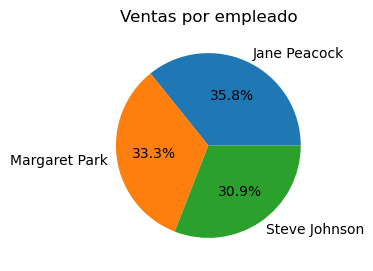

In [99]:
query = """
select Concat(e.FirstName,' ', e.LastName)as Name,  sum(i.Total) as Ventas_Total from invoices i 
inner join customers c on i.CustomerId  = c.CustomerId 
inner join employees e  on e.EmployeeId = c.SupportRepId
group by Name; 

"""
df = pd.read_sql_query(query, conn)
df.set_index("Name")['Ventas_Total'].plot(
    figsize=(3,3),
    kind="pie",   
    legend=False, 
    autopct="%1.1f%%", 
    ylabel="")
plt.title("Ventas por empleado")
plt.show()

## Consultas avanzadas (CTEs, subconsultas, agrupamientos)

### ¿Qué país tiene el mayor gasto promedio por cliente?

In [67]:
query = """
select i.BillingCountry as Country , AVG(i.Total ) as Promedio from invoices i 
group by Country order by Promedio DESC limit 10; 

"""
df = pd.read_sql_query(query, conn)
df.head()

,Country,Promedio
0,Chile,6.660000
1,Ireland,6.517143
2,Hungary,6.517143
3,Czech Republic,6.445714
4,Austria,6.088571


### Encuentra el mes con mayores ventas en toda la historia de ventas en la Base de Datos. Ventas por Año. 

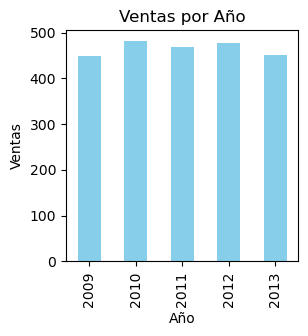

In [211]:
query = """
SELECT 
    strftime('%Y', i.InvoiceDate) AS AnoMes,
    SUM(i.Total) AS Ventas
FROM invoices i
GROUP BY AnoMes
ORDER BY AnoMes Asc;  
"""

df = pd.read_sql_query(query, conn)
df.head()

ventas = df['Ventas']
AnoMes = df['AnoMes'].astype(int)

df.plot(
    kind="bar",        # tipo de gráfico
    x="AnoMes",          # eje X
    y="Ventas",        # eje Y
    legend=False,      # sin leyenda
    color="skyblue", 
     figsize=(3,3)# color opcional
)

plt.title("Ventas por Año")
plt.xlabel("Año")
plt.ylabel("Ventas")
plt.show()

In [212]:
import pmdarima as pm

# Serie como array
y = np.array(ventas)

# Ajuste automático ARIMA
modelo = pm.auto_arima(
    y,
    seasonal=False,     # Son datos anuales (no hay estacionalidad mensual)
    stepwise=True,      # Búsqueda eficiente
    suppress_warnings=True,
    trace=False          # Muestra el proceso de selección
)

print(modelo.summary())

/Users/edgarpreciado/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/edgarpreciado/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/edgarpreciado/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/edgarpreciado/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/edgarpreciado/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                    5
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -18.985
Date:                Mon, 15 Sep 2025   AIC                             43.970
Time:                        22:09:32   BIC                             42.798
Sample:                             0   HQIC                            40.825
                                  - 5                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    838.6070    441.407      1.900      0.057     -26.535    1703.749
ar.L1         -0.7877      0.928     -0.849      0.396      -2.606       1.031
sigma2        95.9028    227.415      0.422      0.6

/Users/edgarpreciado/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


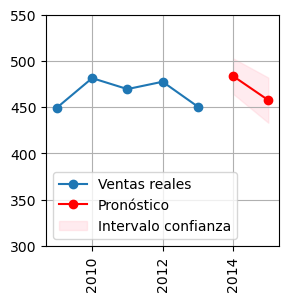

In [214]:
n_periods = 2
pred, conf_int = modelo.predict(n_periods=n_periods, return_conf_int=True)
# Crear rango de fechas mensual
anos_futuros = [2014, 2015]

# Graficar
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
plt.plot(AnoMes, y, marker="o", label="Ventas reales")
plt.ylim(300,550)
plt.plot(anos_futuros, pred, marker="o", label="Pronóstico", color="red")
plt.fill_between(anos_futuros, conf_int[:,0], conf_int[:,1], 
                 color="pink", alpha=0.3, label="Intervalo confianza")
plt.tick_params(axis="x", rotation=90)
plt.legend()
plt.grid(True)
plt.savefig("Preduccion_Ventas.png")
plt.show()

### ¿Qué género prefieren los clientes de USA frente a los de Brasil?
Generaremos dos Histogramas y compararemos; 

In [215]:
query1 = """
SELECT  g.Name, count(g.Name) as Count  FROM invoices i
inner join invoice_items ii on i.InvoiceId = ii.InvoiceId 
inner join tracks t on ii.TrackId = t.TrackId 
inner join genres g on g.GenreId  = t.GenreId 
where   i.BillingCountry in (select i2.BillingCountry  from invoices i2 
where i2.BillingCountry in ('USA'))
group by g.Name order by Count Desc 
limit 10; 
"""

query2 = """
SELECT  g.Name, count(g.Name) as Count  FROM invoices i
inner join invoice_items ii on i.InvoiceId = ii.InvoiceId 
inner join tracks t on ii.TrackId = t.TrackId 
inner join genres g on g.GenreId  = t.GenreId 
where   i.BillingCountry in (select i2.BillingCountry  from invoices i2 
where i2.BillingCountry in ('Brazil'))
group by g.Name order by Count Desc
limit 10; 
"""

df_usa = pd.read_sql_query(query1, conn)
df_Brazil = pd.read_sql_query(query2, conn)

Count_USA = df_usa['Count']
Name_USA = df_usa['Name']

Count_B = df_Brazil['Count']
Name_B = df_Brazil['Name']


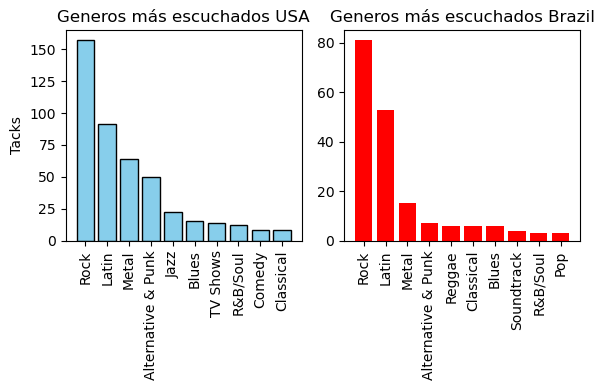

In [216]:
# Crear figura con 2 subplots (2 filas, 1 columna)
fig, axs = plt.subplots(1, 2, figsize=(6, 4))

# Primer subplot
axs[0].bar(Name_USA, Count_USA, color="skyblue", edgecolor="black")
axs[0].set_title("Generos más escuchados USA")
axs[0].set_ylabel("Tacks")
axs[0].tick_params(axis="x", rotation=90)
# Segundo subplot
axs[1].bar(Name_B, Count_B, color="red")
axs[1].set_title("Generos más escuchados Brazil")
axs[1].tick_params(axis="x", rotation=90)

# Ajustar espacios entre gráficos
plt.tight_layout()
plt.savefig("Generos_USAB.png")


plt.show()

### ¿Cuál es el promedio de duración (en minutos) de las canciones por género?

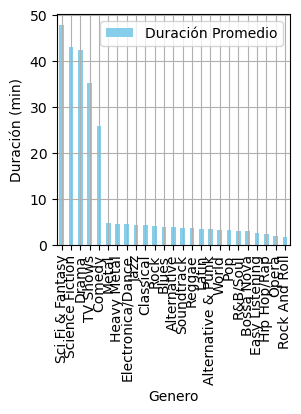

In [219]:
query = """
select g.Name as Genero , Round(Avg(t.Milliseconds/60000),1)  as p_minutes from tracks t
inner join genres g on g.GenreId = t.GenreId 
GROUP  by Genero order by p_minutes Desc;  
"""

df = pd.read_sql_query(query, conn)
df.head()

df.plot(
    kind="bar",        # tipo de gráfico
    x="Genero",          # eje X
    y="p_minutes",        # eje Y
    legend=True,      # sin leyenda
    color="skyblue",     # color opcional
    label = 'Duración Promedio', 
     figsize=(3,3)
)
plt.ylabel("Duración (min)")
plt.grid()
plt.show()

### ¿Cuál es el ingreso total generado por cada artista?

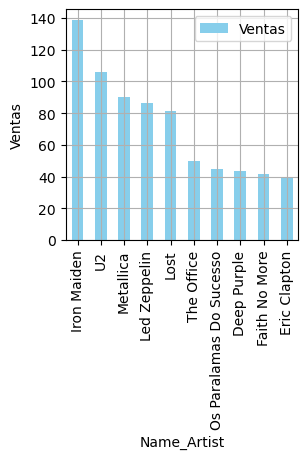

In [116]:
query = """
select ar.Name as Name_Artist, Sum(ii.UnitPrice) as Ventas from invoices i
inner join invoice_items ii on i.InvoiceId = ii.InvoiceId
inner join tracks t on ii.TrackId = t.TrackId
inner JOIN albums a on a.AlbumId = t.AlbumId 
inner join artists ar on a.ArtistId = ar.ArtistId 
group by Name_Artist order by Ventas DESC limit 10; 
"""

df = pd.read_sql_query(query, conn)
df.head()

df.plot(
    kind="bar",        # tipo de gráfico
    x="Name_Artist",          # eje X
    y="Ventas",        # eje Y
    legend=True,      # sin leyenda
    color="skyblue",     # color opcional
    label = 'Ventas', 
    figsize=(3,3)
)
plt.ylabel("Ventas")
plt.grid()
plt.show()

### -- ¿Qué porcentaje de ventas representan los 3 artistas más vendidos respecto al total?

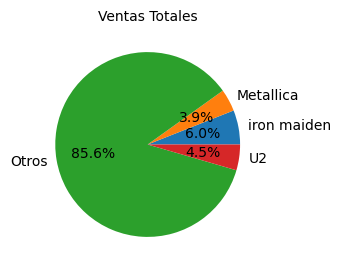

In [220]:
query = """
select ar.Name as Name_Artist, Round(Sum(ii.UnitPrice)*100/2328.6,1) as P_Ventas from invoices i
inner join invoice_items ii on i.InvoiceId = ii.InvoiceId
inner join tracks t on ii.TrackId = t.TrackId
inner JOIN albums a on a.AlbumId = t.AlbumId 
inner join artists ar on a.ArtistId = ar.ArtistId 
group by Name_Artist order by P_Ventas DESC limit 3; 
"""

df = pd.read_sql_query(query, conn)

P_Iron = df['P_Ventas'][0]
P_u2 = df['P_Ventas'][1]
P_Metallica = df['P_Ventas'][2]
P_Otros = 100-P_Metallica-P_u2-P_Iron

plt.figure(figsize=(3,3))
plt.pie([P_Iron, P_Metallica, P_Otros, P_u2],  labels=['iron maiden','Metallica', 'Otros', 'U2' ],  autopct='%1.1f%%')
#plt.pie(df["Ingreso_Total"], labels=df["Artista"], autopct="%1.1f%%", startangle=140)
plt.title("Ventas Totales", fontsize = 10)
plt.savefig("Ventas_Totales.pdf")

plt.show()


### -- Ranking de clientes: ¿Quiénes son los 10 más valiosos (highest lifetime value)?


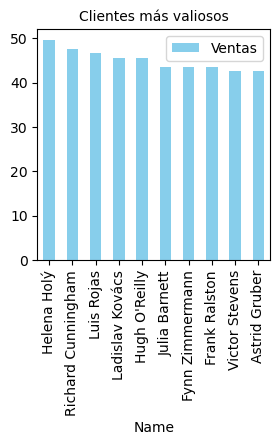

In [218]:
query = """
select Concat(c.FirstName, ' ', c.LastName) as Name, Round(Sum(i.Total),1) as LifetimeValue from invoices i 
inner join customers c on c.CustomerId = i.CustomerId
group by Name order by LifetimeValue  desc limit 10; 
"""

df = pd.read_sql_query(query, conn)
df.plot(
    kind="bar",        # tipo de gráfico
    x="Name",          # eje X
    y="LifetimeValue",        # eje Y
    legend=True,      # sin leyenda
    color="skyblue",     # color opcional
    label = 'Ventas', 
 figsize=(3,3))

plt.title("Clientes más valiosos", fontsize = 10)
plt.savefig("Clientes_más_valiosos.png")

plt.show()

###  Which Music Genres Should We Focus on in the USA?

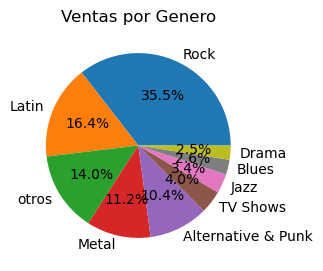

,Genero,Perc
0,Rock,35.499871
1,Latin,16.410719
2,otros,14.002405
3,Metal,11.223911
4,Alternative & Punk,10.373615


In [217]:
query = """
SELECT Genero, SUM(P_Ventas ) as Perc  from (select g.Name as Genre, Sum(ii.UnitPrice)*100/2328.6 as P_Ventas, 
	case 
		when Sum(ii.UnitPrice)*100/2328.6 > 2 then g.Name
		ELSE
			'otros'
		END as Genero
from invoices i
inner join invoice_items ii on i.InvoiceId = ii.InvoiceId
inner join tracks t on ii.TrackId = t.TrackId
inner JOIN albums a on a.AlbumId = t.AlbumId 
inner join artists ar on a.ArtistId = ar.ArtistId 
inner join genres g on g.GenreId = t.GenreId 
group by Genre 
order by P_Ventas DESC) group by GEnero order by Perc DESC ; 
"""

df = pd.read_sql_query(query, conn)

df.set_index("Genero")['Perc'].plot(
    figsize=(3,3),
    kind="pie",   
    legend=False, 
    autopct="%1.1f%%", 
    ylabel="")
plt.title("Ventas por Genero")
plt.savefig("Ventas_por_genero.png")
plt.show()


df.head()

In [16]:
conn.close()